In [51]:
#import statements
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer




from scipy import sparse
import scipy.stats as st
from scipy.stats import skew


sns.set()

In [2]:
housing = pd.read_csv('../data/train.csv')
# Log transform the target for official scoring
housing.SalePrice = np.log1p(housing.SalePrice)


In [3]:
split = StratifiedShuffleSplit(n_splits=1, test_size = 0.2, random_state=21)
for train_ix, test_ix in split.split(housing, housing['MSZoning']):
    df_train = housing.loc[train_ix]
    df_test = housing.loc[test_ix]

Things to do (housing continuous):

- Use total SF instead of 1st fl and 2fl
- Make Low Qual SF into categorical (1 - has low qual; 0 - no low qual)
- If remodeled and year >1950 - then continuous else 0
- drop 1st fl SF and 2nd fl SF
- drop basement SF other than total
- remove outliers
- add polynomials to top variables
- Normalize remaining columns

Things to do (lot continuous):

- Option to cut off tails
- Option to log-transform
- Normalize remaining columns

Things to do (garage and misc continuous):

- Make PoolArea, ScreenPorch, 3SnPorch, and Enclosed Porch categorical (0,1)
- Drop Garage year built?
- Combine GarageCars and GarageArea into single feature, drop others
- Drop MiscVal
- add polynomials to top variables
- Normalize remaining columns

Things to do (house ordinal):

- Use Overall Qual
- Drop OveralCond
- Convert 'ExterQual','BsmtQual', 'BsmtCond', 'BsmtFinType1', 'KitchenQual, 'Functional' to numeric
- Drop 'ExterCond'
- Convert 'BsmtFinType2' to cat (0, 1)
- Combine 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath' to Bathrooms
- Collapse bathrooms >4 to 4
- Drop BedroomAbvGr
- Collapse TotRmsAbvGrd > 10 to 10
- add polynomials to top variables?
- Normalize remaining columns

Things to do (lot ordinal):

- Convert 'LotShape' to numeric
- Drop 'LandSlope'
- Normalize remaining columns

Things to do (garage and misc ordinal):

- Convert 'HeatingQC', 'FireplaceQu', 'PoolQC', 'GarageQual', to numeric
- Drop 'GarageCars'
- Drop 'GarageCond'
- Drop 'PoolQC'
- add polynomials to top variables
- Normalize remaining columns

Things to do (house categorical):

- One_hot_encode 'MSSubClass', 'BldgType', 'HouseStyle'

Things to do (lot categorical):

- Fill NA with 'None' where appropriate
- One_hot_encode 'MSZoning', 'Street', 'Alley','LandContour','LotConfig', 'Neighborhood' 
- Convert 'Utilities' to 1 if all utils 0 if missing some
- Convert 'Condition1' and 'Condition2' to 1 if normal 0 else

Things to do (Garage and misc categorical):

- Fill 'Fence','GarageType' NA with 'None' 
- One_hot_encode 'GarageType', 'RoofStyle', 'MasVnrType','Foundation',
    'Heating', 'CentralAir','Electrical', 'PavedDrive','MoSold',
    'YrSold','SaleCondition', 'Fence'
- Collapse rare 'Exterior1st', 'Exterior2nd', 'SaleType' to 'Other' then one_hot_encode
- Convert 'RoofMatl' to 1 if CompShg 0 if else
- Drop 'MiscFeature'

In [4]:
#Ordinal text to numeric helper functions

def condToNum(df, col):
    df = df.fillna({col: "NA"})
    condition_nums = {col:  {"NA":0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}}
    
    df.replace(condition_nums, inplace=True)
    return df

def finToNum(df, col):
    df = df.fillna({col: "NA"})
    fin_nums = {col:  {"NA":0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}}
    
    df.replace(fin_nums, inplace=True)
    return df

def funcToNum(df, col):
    df = df.fillna({col: "NA"})
    func_nums = {col:  {"Sal":0, "Sev": 1, "Maj2": 2, "Maj1": 3, "Mod": 4, "Min2": 5, "Min1": 6, "Typ": 7, "NA":7}}
    
    df.replace(func_nums, inplace=True)
    return df

def shapeToNum(df, col):
    df = df.fillna({col: "NA"})
    shape_nums = {col:  {"IR3":0, "IR2": 1, "IR1": 2, "Reg": 3, "NA": 3}}
    
    df.replace(shape_nums, inplace=True)
    return df

def slopeToNum(df, col):
    df = df.fillna({col: "NA"})
    slope_nums = {col:  {"Gtl":0, "Mod": 1, "Sev": 2, "NA": 0}}
    
    df.replace(slope_nums, inplace=True)
    return df

def garFinToNum(df, col):
    df = df.fillna({col: "NA"})
    slope_nums = {col:  {"NA":0, "Unf": 1, "RFn": 2, "Fin": 3}}
    
    df.replace(slope_nums, inplace=True)
    return df

def exposToNum(df, col):
    df = df.fillna({col: "None"})
    expos_nums = {col:  {"None":0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}}
    
    df.replace(expos_nums, inplace=True)
    return df

In [5]:
#Use DataFrame for preprocessing of text ordinal features

def text_preprocessing(df):
    qual_ordin_cols= ['HeatingQC', 'FireplaceQu', 'PoolQC', 'GarageQual'
                      , 'GarageCond', 'ExterQual', 'BsmtQual', 'BsmtCond', 'KitchenQual']
    for col in qual_ordin_cols:
        df = condToNum(df,col)
    
    df = shapeToNum(df,'LotShape')
    df = slopeToNum(df,'LandSlope')
    df = garFinToNum(df,'GarageFinish')
    df = finToNum(df,'BsmtFinType1')
    df = finToNum(df,'BsmtFinType2')
    df = funcToNum(df, 'Functional')
    df = exposToNum(df,'BsmtExposure')
    df = df.fillna({'Fence': 'None'})
    df = df.fillna({'Alley': 'None'})
    df = df.fillna({'GarageType': 'None'})
    df = df.fillna({'MasVnrType': 'None'})
    
    return df

In [6]:
def remove_outliers(df):
    #Remove obvious outliers
    
    liv_cut = df[(df['GrLivArea']>4000)& (df['SalePrice']<300000)]
    
    lot_cut = df[((df['LotArea']>30000) & (df['SalePrice']<500000)) | 
                   ((df['LotFrontage']>300) & (df['SalePrice']<500000))]
    bsmt_cut = df[(df['TotalBsmtSF']>0)&(df['TotalBsmtSF']>5000)& (df['SalePrice']<200000)]
    
    indicies = liv_cut.index.values.tolist()
    
    for ind in lot_cut.index.values.tolist():
        if ind not in indicies:
            indicies.append(ind)
    
    for ind in bsmt_cut.index.values.tolist():
        if ind not in indicies:
            indicies.append(ind)
            
    df.drop(indicies, inplace=True)
    
    return df

In [7]:
def add_special_dummies(df, a):
    #Add dummies from continuous variables to better handle zeros
    
    df['has_YearRemod'] = np.where(
                        (df['YearRemodAdd']!=df['YearBuilt'])& (
                         df['YearRemodAdd']>1950), 1,0)
    
    df['has_allUtil'] = np.where(df['Utilities']=='AllPub',1,0)
    
    df['has_normCond1'] = np.where(df['Condition1']=='Norm',1,0)
    df['has_normCond2'] = np.where(df['Condition2']=='Norm',1,0)
    
    df['roof_isCompShg'] = np.where(df['RoofMatl']=='CompShg',1,0) 
    
    df['has_MasVnr'] = np.where(df['MasVnrArea']>0, 1,0)
    df['has_Basement'] = np.where(df['TotalBsmtSF']>0, 1,0)
    df['has_LowQualSF'] = np.where(df['LowQualFinSF']>0, 1,0)
    df['has_EncPor'] = np.where(df['EnclosedPorch']>0, 1,0)
    df['has_3SsnPor'] = np.where(df['3SsnPorch']>0, 1,0)
    df['has_WoodDeck'] = np.where(df['WoodDeckSF']>0, 1,0)
    df['has_OpenPorch'] = np.where(df['OpenPorchSF']>0, 1,0)
    df['has_ScnPorch'] = np.where(df['ScreenPorch']>0, 1,0)
    df['has_Pool'] = np.where(df['PoolArea']>0, 1,0)
    
    
    cols_added = ['has_YearRemod', 'has_allUtil', 'has_normCond1', 'has_normCond2'
                  ,'roof_isCompShg', 'has_MasVnr', 'has_Basement', 'has_LowQualSF'
                  , 'has_EncPor', 'has_3SsnPor', 'has_WoodDeck', 'has_OpenPorch'
                  , 'has_ScnPorch', 'has_Pool']
    
    for col in cols_added:
        a.append(col)
    
    return df, a

In [8]:
def add_attributes(df, n, a, combine_garage=False):
    
    #add additional attributes
    #Total bathrooms, combine garage features, collapse rare features into 'other' 
    
    df['Bathrooms_tot'] = df['BsmtFullBath']+0.5*df['BsmtHalfBath']+df['FullBath']+0.5*df['HalfBath']
    df['Bathrooms_tot'] = np.where(df['Bathrooms_tot'] > 3.5, 4, df['Bathrooms_tot'])
    
    if combine_garage:
        df['GarageComb'] = df['GarageArea']*df['GarageCars']
        n.append('GarageComb')
        
    else:
        df['has_Garage'] = np.where(df['GarageArea']>0, 1,0)
        a.append('has_Garage')
        n.append('GarageArea')
        
    #collapse some of the rare features into 'Other'    
    ext1 = df.groupby(['Exterior1st'])['Id'].count()
    ext1 = ext1[ext1 <5]
    
    for ext in ext1.index:
        df['Exterior1st'] = np.where(df['Exterior1st']==ext, 'Other', df['Exterior1st'])
        
    ext2 = df.groupby(['Exterior2nd'])['Id'].count()
    ext2 = ext2[ext2 <5]    
    
    for ext in ext2.index:
        df['Exterior2nd'] = np.where(df['Exterior2nd']==ext, 'Other', df['Exterior2nd'])
        
    sale = df.groupby(['SaleType'])['Id'].count()
    sale = sale[sale < 8]
    
    for s in sale.index:
        df['SaleType'] = np.where(df['SaleType']==s, 'Other', df['SaleType'])
        
    n.append('Bathrooms_tot')
    
    
    return df, n, a

In [9]:
def preprocess_features(df, numer, addedc, combine_garage=False):
    #Combine preprocessing steps
    df_temp = remove_outliers(df)
    df_temp = text_preprocessing(df_temp)
    df_temp, addedc = add_special_dummies(df_temp, addedc)
    df_temp, numer, addedc = add_attributes(df_temp, numer, addedc, combine_garage=combine_garage)
    
    return df_temp, numer, addedc

In [292]:
def process_features(df, dftest, numeric, cate, added,drop=True, add_poly=False):
    

    add_poly=add_poly

    #Numerical columns
    imputer_med = Imputer(strategy='median')
    scaler = StandardScaler()

    df_tr = df[numeric+cate+added].copy()
    dftest_tr = dftest[numeric+cate+added].copy()
    #reset index
    df_tr.reset_index(drop=True, inplace=True)
    dftest_tr.reset_index(drop=True, inplace=True)

    #Numerical columns
    
    df_tr[numeric] = imputer_med.fit_transform(df_tr[numeric])
    
    dftest_tr[numeric] = imputer_med.transform(dftest_tr[numeric])
    
    for d in [df_tr, dftest_tr]:
        if add_poly:
            new_cols=[]
            for c in numeric:
                d[c+'^2']=d[c]*d[c]
                d[c+'^3']=d[c]*d[c]*d[c]
                new_cols.append(c+'^2')
                new_cols.append(c+'^3')
        
            all_num = numeric+new_cols
    
        else:
            all_num = numeric 
            
    skewness = df_tr[all_num].apply(lambda x: skew(x))
    skewness = skewness[abs(skewness) > 0.5]
    print(str(skewness.shape[0]) + " skewed numerical features to log transform")
    skewed_features = skewness.index
    df_tr[skewed_features] = np.log1p(df_tr[skewed_features])
    dftest_tr[skewed_features] = np.log1p(dftest_tr[skewed_features])
        
    #Scale data
    df_tr[all_num] = scaler.fit_transform(df_tr[all_num])  
    dftest_tr[all_num] = scaler.transform(dftest_tr[all_num])
    
    #Categorical Columns    
    final_df = pd.get_dummies(df_tr, columns = cate, drop_first=drop)
    final_df_test = pd.get_dummies(dftest_tr, columns = cate, drop_first=drop)
    
    
    return final_df, final_df_test

In [293]:
num_model = ['YearBuilt', 'YearRemodAdd', 'TotalBsmtSF','GrLivArea'
                , 'LotFrontage', 'LotArea','MasVnrArea', 'WoodDeckSF'
                , 'OpenPorchSF','OverallQual', 'TotRmsAbvGrd', 'ExterQual'
                , 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1'
                , 'HeatingQC',  'Fireplaces', 'FireplaceQu','GarageFinish'
                , 'GarageQual', 'LotShape', 'KitchenQual','Functional']

    
cat_model = ['MSSubClass','MSZoning', 'Street', 'LandContour','LotConfig'
                    , 'Neighborhood', 'BldgType', 'HouseStyle','RoofStyle', 'MasVnrType'
                    , 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'PavedDrive'
                    ,  'MoSold', 'YrSold', 'SaleType', 'SaleCondition' 
                    , 'Exterior1st','Exterior2nd','Alley','GarageType','Fence']



special_model = ['Utilities','Condition1', 'Condition2', 'RoofMatl'
                 , 'LowQualFinSF', 'GarageArea','GarageCars'
                ,'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea']

added_cols = []


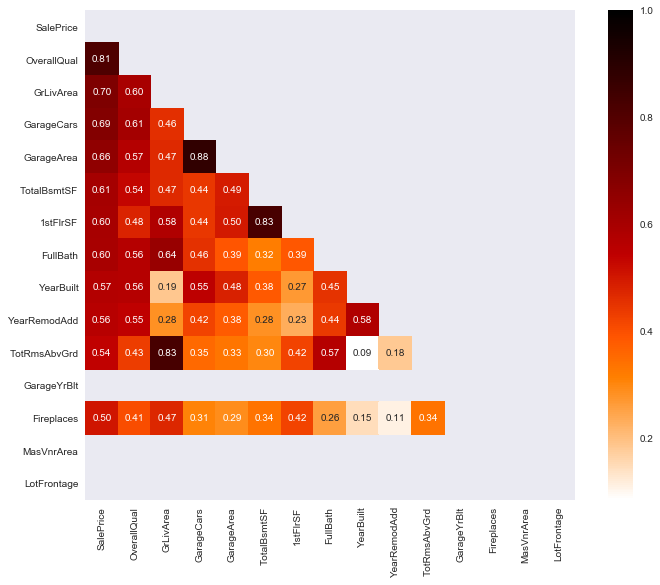

In [294]:
#saleprice correlation matrix
corr = df_train.corr()

cols = corr.nlargest(15, 'SalePrice').index

cm = np.corrcoef(df_train[cols].values.T)

mask = np.zeros_like(cm, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 9))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values,
                 xticklabels=cols.values, cmap='gist_heat_r', mask=mask)
plt.show()

In [295]:
df_train_tr = df_train.copy()
df_test_tr = df_test.copy()

In [296]:
added_cols = []
df_train_tr, num, add = preprocess_features(df_train_tr, num_model, added_cols, combine_garage=True)


In [297]:
final_num = num.copy()
final_cat = cat_model.copy()
final_added = add.copy()

In [298]:
df_test_tr, _, _ = preprocess_features(df_test_tr, num_model, added_cols, combine_garage=True)

In [299]:
df_train_tr_label = df_train_tr.pop('SalePrice')
df_test_tr_label = df_test_tr.pop('SalePrice')

In [300]:
test_fr = df_train_tr.copy()
test_lb = df_train_tr_label.copy()

In [301]:
final_df, final_test_df = process_features(df_train_tr, df_test_tr, final_num,
                            final_cat, final_added, drop=True, add_poly=True)

61 skewed numerical features to log transform


In [302]:
final_df.head()

,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,LotFrontage,LotArea,MasVnrArea,WoodDeckSF,OpenPorchSF,OverallQual,...,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None
0,0.258411,-0.280424,0.076913,-1.269038,0.154874,-0.485974,-0.819474,0.514666,-1.073254,-0.813171,...,0,0,0,0,1,0,0,0,0,1
1,-0.781691,-1.696079,0.062195,0.882418,1.131515,0.546382,1.580439,-0.934982,-1.073254,-0.813171,...,0,0,0,0,1,0,0,0,0,1
2,-0.545390,0.988783,0.268618,-0.634657,-0.980367,-0.894255,-0.819474,0.977805,1.070332,-2.287807,...,1,0,0,0,0,0,0,0,0,1
3,1.151123,1.037599,0.344413,-0.387474,-0.336593,-0.435017,0.782748,-0.934982,1.163944,-0.075853,...,1,0,0,0,0,0,0,0,0,1
4,0.324954,-0.182793,0.465563,0.011786,0.154874,0.763573,1.352512,-0.934982,-1.073254,-0.075853,...,1,0,0,0,0,0,0,0,0,1


In [303]:
final_test_df.head()

,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,LotFrontage,LotArea,MasVnrArea,WoodDeckSF,OpenPorchSF,OverallQual,...,Alley_Pave,GarageType_Attchd,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None
0,0.821897,0.598258,0.005066,0.612188,0.154874,0.118070,0.603796,0.983158,1.171591,-0.075853,...,0,1,0,0,0,0,0,0,0,1
1,1.052527,0.891152,0.414429,1.127590,-0.181165,0.561738,-0.819474,1.238161,1.481472,0.661465,...,0,0,0,0,1,0,0,0,0,1
2,-0.646558,-1.598447,-6.217450,-1.265832,0.332313,0.318020,-0.819474,-0.934982,-1.073254,-2.287807,...,0,0,0,0,1,0,0,0,0,1
3,-2.079460,0.549442,-0.253331,-0.580512,-0.444519,-0.099742,-0.819474,-0.934982,1.270346,-0.813171,...,0,0,0,0,0,1,0,0,0,1
4,0.191801,-0.378055,0.267037,1.039084,0.699211,0.275088,1.338886,1.248981,1.152232,0.661465,...,0,1,0,0,0,0,0,0,0,1


In [304]:
def add_missing_dummy_columns(d, columns ):
    #Some categories were missing in test set- add colums as zeros
    missing_cols = set( columns ) - set( d.columns )
    for c in missing_cols:
        d[c] = 0

In [305]:
def fix_columns( d, columns ):  
    
    #Add missing columns and check if there are any extra in the test set
    add_missing_dummy_columns( d, columns )

    # make sure we have all the columns we need
    assert( set( columns ) - set( d.columns ) == set())

    extra_cols = set( d.columns ) - set( columns )
    if extra_cols:
        print("extra columns:", extra_cols)

    d = d[ columns ]
    return d

In [306]:
#add missing columns to test set
fixed_test = fix_columns(final_test_df.copy(), final_df.columns.values.tolist() )

In [307]:
final_df_label = df_train_tr_label.reset_index(drop=True).copy()
final_test_df_label = df_test_tr_label.reset_index(drop=True).copy()

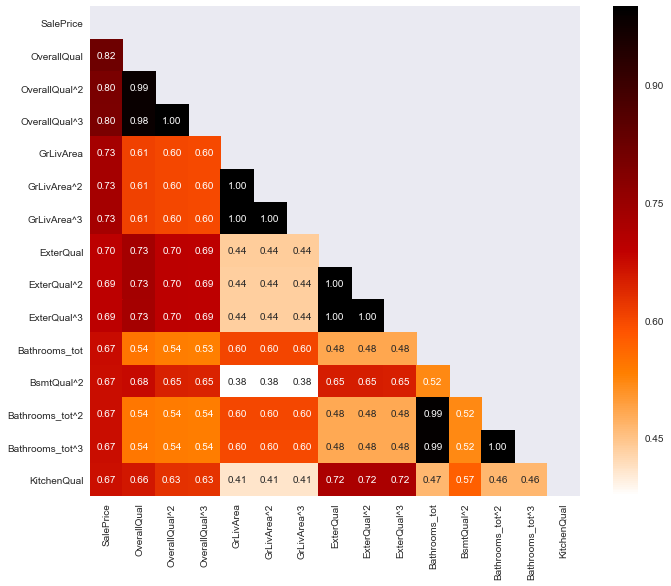

In [309]:
#saleprice correlation matrix with final data frame after processing
temp = final_df.copy()
temp['SalePrice'] = final_df_label.copy()
corr = temp.corr()

cols = corr.nlargest(15, 'SalePrice').index

cm = np.corrcoef(temp[cols].values.T)

mask = np.zeros_like(cm, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 9))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values,
                 xticklabels=cols.values, cmap='gist_heat_r', mask=mask)
plt.show()